## Importando librerías

In [1]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

2022-04-18 21:30:46.679781: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt 

## Cargando dataset

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 12s 0us/step


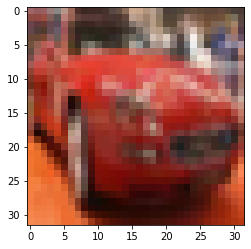

In [4]:
plt.imshow(x_train[5])

## Limpieza de datos

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [6]:
num_clases = len(np.unique(y_train))
y_train = to_categorical(y_train, num_clases)
y_test = to_categorical(y_test, num_clases)

In [7]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

### Normalization

In [8]:
mean = np.mean(x_train)
std = np.std(x_train)

In [9]:
x_train = (x_train - mean) / (std+1e-7)
x_test = (x_test - mean) / (std+1e-7)

## Creando set de datos

In [10]:
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

print('x_train shape', x_train.shape)

print('train;', x_train.shape[0])
print('val;', x_valid.shape[0])
print('test;', x_test.shape[0])

x_train shape (45000, 32, 32, 3)
train; 45000
val; 5000
test; 10000


## Construyendo nuestro modelo convolucional

In [11]:
base_filtros = 32
w_regulatizer = 1e-4

In [12]:
x_train.shape[1:]

(32, 32, 3)

In [13]:
model = Sequential()
## conv 1
model.add(Conv2D(base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

## conv 2
model.add(Conv2D(base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

## conv 3
model.add(Conv2D(2*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

## conv 4
model.add(Conv2D(2*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

## conv 5
model.add(Conv2D(4*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())


## conv 6
model.add(Conv2D(4*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

## Clasificacion - Flatten

model.add(Flatten())
model.add(Dense(num_clases,activation='softmax'))

model.summary()



2022-04-18 21:31:07.988401: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-18 21:31:07.991543: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-18 21:31:08.044921: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 21:31:08.045674: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-04-18 21:31:08.045747: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-04-18 21:31:08.100239: I tensorflow/stream_executor/platform/def

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

## Data augmentation

In [14]:
datagen = ImageDataGenerator(rotation_range=15,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  horizontal_flip=True,
                  vertical_flip=True)

## Compilando

In [15]:
from tensorflow.keras import optimizers

In [16]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(),
             metrics=['accuracy'])

In [17]:
#hist = model.fit(x_train, y_train, batch_size=32,epochs=100,
#                validation_data=(x_valid, y_valid),
#                verbose=2, shuffle=True)

## Callbacks

In [18]:
chekcpoint = ModelCheckpoint('mi_mejor_modelo.hdf5',verbose=1,save_best_only=True, monitor = 'val_accuracy')

## Entrenando nuestro modelo

In [19]:
hist = model.fit(datagen.flow(x_train, y_train, batch_size=128),
          callbacks=[chekcpoint],
          steps_per_epoch=x_train.shape[0] // 128, 
          epochs=120,
          verbose=2,
          validation_data=(x_valid, y_valid)
         )

2022-04-18 21:31:11.241099: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-18 21:31:11.244969: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000140000 Hz


Epoch 1/120


2022-04-18 21:31:12.318513: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-04-18 21:31:13.187392: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-04-18 21:31:13.210527: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


351/351 - 32s - loss: 2.2491 - accuracy: 0.3215 - val_loss: 2.1307 - val_accuracy: 0.2942

Epoch 00001: val_accuracy improved from -inf to 0.29420, saving model to mi_mejor_modelo.hdf5
Epoch 2/120
351/351 - 23s - loss: 1.7164 - accuracy: 0.4319 - val_loss: 1.7246 - val_accuracy: 0.4414

Epoch 00002: val_accuracy improved from 0.29420 to 0.44140, saving model to mi_mejor_modelo.hdf5
Epoch 3/120
351/351 - 24s - loss: 1.5042 - accuracy: 0.4972 - val_loss: 1.5014 - val_accuracy: 0.5152

Epoch 00003: val_accuracy improved from 0.44140 to 0.51520, saving model to mi_mejor_modelo.hdf5
Epoch 4/120
351/351 - 23s - loss: 1.3736 - accuracy: 0.5440 - val_loss: 1.2943 - val_accuracy: 0.5680

Epoch 00004: val_accuracy improved from 0.51520 to 0.56800, saving model to mi_mejor_modelo.hdf5
Epoch 5/120
351/351 - 23s - loss: 1.2777 - accuracy: 0.5694 - val_loss: 1.1595 - val_accuracy: 0.6242

Epoch 00005: val_accuracy improved from 0.56800 to 0.62420, saving model to mi_mejor_modelo.hdf5
Epoch 6/120
351

## Resultados

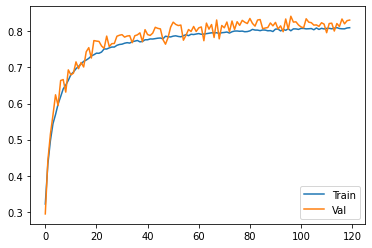

In [20]:
plt.plot(hist.history['accuracy'],label='Train')
plt.plot(hist.history['val_accuracy'],label='Val')
plt.legend()
plt.show()

In [21]:
model2 = model

In [22]:
model2.load_weights('./mi_mejor_modelo.hdf5')

In [23]:
model2.evaluate(x_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.6489 - accuracy: 0.8327


[0.6488964557647705, 0.8327000141143799]